## Misc functions for dealing with assembly data

Get subset of assemblies and use lineage info for a subset to get a filtered reference set. 

Then use as training data or for matching other strains in our assembly set to get their lineage.

In [2]:
import os, sys, io, random, subprocess, re
import string
import urllib
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',600)
import pylab as plt

from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from mtbdiff import utils, analysis

## make bioproject table

may be useful later

In [2]:
from IPython.display import clear_output, display

def get_bioproject_table():
    proj = asm.BioProject.unique()
    print (len(proj))
    res=[]
    for id in proj:    
        clear_output(wait=True)
        if id.find('PRJNA|PRJEB'):
            id = id[5:]
        print (id)
        try:
            d = get_bioproject_info(id)
            s = pd.Series(d)
            res.append(s)
        except:
            pass

    res=pd.Data
    print (len(res))
    res.to_csv('../mtb_bioprojects.csv',index=False)

## get extra fields for mtb assemblies

In [3]:
asm = utils.get_mtb_assembly_data()
#asm['Assembly_nover'] = asm.Assembly.apply(lambda x: x.split('.')[0],1)
print (asm.columns)
variants = ['ofxr','haarlem','kzn','btb09','btb10','btb05','btb11']
species = ['bcg','bovis','h37rv','h37ra','cdc1551','beijing',           
           'africanum','africanum','marinum','canettii','ulcerans',
           'caprae','orygis','microti','pinnipedii']
def get_species(x):
    for s in species:
        if x.find(s) > 0:
            return s
    return 'mtb'

x=asm.Organism_Name.str.lower().apply(get_species)
x.value_counts()

Index(['Organism_Name', 'Strain', 'CladeID', 'BioSample', 'BioProject', 'Group', 'SubGroup', 'Assembly', 'Size (Mb)', 'GC%', 'Replicons', 'WGS', 'Scaffolds', 'Genes', 'Proteins', 'Release Date', 'Modify Date', 'Level', 'RefSeq FTP', 'GenBank FTP', 'species', 'Assembly_nover'], dtype='object')


mtb           6392
bovis           70
bcg             37
africanum       31
marinum         25
canettii         9
h37rv            9
ulcerans         7
cdc1551          3
microti          3
caprae           3
h37ra            3
pinnipedii       3
orygis           2
beijing          2
Name: Organism_Name, dtype: int64

In [ ]:
from wordcloud import WordCloud, STOPWORDS
text = ' '.join(asm.Organism_Name)
wordcloud = WordCloud(
    width = 2500,
    height = 1000,
    background_color = 'white',
    min_font_size=10,
    max_font_size=160,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (20,15),
    facecolor = 'w',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")

In [49]:
#asm.Organism_Name.value_counts()[:20]
asm.BioProject.value_counts()[:10]

PRJNA343736    1643
PRJEB2138      1000
PRJEB5280       470
PRJEB2221       387
PRJNA476470     337
PRJEB2057       196
PRJEB2777        99
PRJNA407834      68
PRJEB2424        51
PRJNA288586      34
Name: BioProject, dtype: int64

In [41]:
bio = pd.read_csv('../mtbdiff/data/mtb_bioprojects.csv')
print (bio.columns)
bio=bio.fillna('-')
bio.Submitter_Organization.value_counts()[:10]
#x=bio[bio.Project_Description.str.contains('Beijing')]
#x['Project_Description']

Index(['TaxId', 'Project_Id', 'Project_Acc', 'Sort_By_ProjectType', 'Sort_By_DataType', 'Sort_By_Organism', 'Project_Subtype', 'Project_Target_Scope', 'Registration_Date', 'Project_Name', 'Project_Title', 'Project_Description', 'Organism_Name', 'Organism_Strain', 'Organism_Label', 'Sequencing_Status', 'Submitter_Organization'], dtype='object')


Broad Institute                                          1622
Texas A&M University                                       78
Vanderbilt University                                      37
International Tuberculosis Research Center                 29
LAU                                                        13
Shanghai Jiao Tong University School of Medicine           10
University of Malaya                                        8
Vavilov Institute of General Genetics                       7
Institute of Microbiology Chinese Academy of Sciences       6
VISION RESEARCH FOUNDATION, SANKARA NETHRALAYA              6
Name: Submitter_Organization, dtype: int64

## make filtered set

In [23]:
icols = ['Assembly_nover','Strain','BioProject','#Organism/Name','species']
filtered = asm[(asm.Level=='Complete Genome') | (~asm.species.isin(['mtb']))]
print (len(filtered))
print (filtered.species.value_counts())

364
mtb           155
bovis          70
BCG            37
africanum      31
marinum        25
canettii        9
H37Rv           9
ulcerans        7
CDC             7
pinnipedii      3
caprae          3
microti         3
H37Ra           3
orygis          2
Name: species, dtype: int64


In [6]:
refs = pd.read_csv('../mtbdiff/data/ref_genomes.csv')
refs[:1]
#asm.merge(refs,on='BioSample')

,Accession,Paired,Lineage,Origin,BioProject,BioSample,Read length,Link1,Link2,Reference
0,ERR2642516,no,caprae,NaN,PRJEB27266,SAMEA4732081,51,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR264/006/...,NaN,Brites et al. 2018


## Fetch raw reads and assemble genomes for known MTB lineages reference set

In [27]:
path = '../read_data'
assembly_path = '../ref_assemblies'
refs = refs[refs.Lineage.str.contains('tuberculosis')]
for i, row in list(refs.iterrows())[:5]:
    print (row.Accession,row.Lineage)
    f1 = os.path.join(path,os.path.basename(row.Link1))  
    if row.Paired == 'yes':
        f2 = os.path.join(path,os.path.basename(row.Link2))    
    else: 
        f2=None
    if not os.path.exists(f1):        
        urllib.request.urlretrieve(row.Link1, f1)
        if f2 != None:
            urllib.request.urlretrieve(row.Link2, f2)
    #do assembly
    out = os.path.join(assembly_path, row.Accession)
    if os.path.exists(out):
        continue
    if row.Paired == 'yes':
        cmd = '/local/SPAdes-3.13.0-Linux/bin/spades.py -t 12 --pe1-1 %s --pe1-2 %s --careful -o %s --only-assembler' \
            %(f1,f2,out)
    else:
        cmd = '/local/SPAdes-3.13.0-Linux/bin/spades.py -t 12 -s %s --careful -o %s --only-assembler' %(f1,out)
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    

ERR233356 tuberculosis L1
ERR1200629 tuberculosis L1
ERR234155 tuberculosis L1
ERR234238 tuberculosis L1
ERR234272 tuberculosis L1


## run mtbdiff on ref lineages 

In [32]:
names = analysis.run_genomes('../ref_genomes', outpath='../ref_results')
struct, snp =  utils.get_nucdiff_results('../ref_results', names)
struct = utils.annotate_results(struct)

../ref_genomes/ERR234155.fa ERR234155
../ref_genomes/ERR233356.fa ERR233356
../ref_genomes/ERR1200629.fa ERR1200629
../ref_genomes/ERR234272.fa ERR234272
../ref_genomes/Mbovis.fna Mbovis
../ref_genomes/ERR234238.fa ERR234238


In [33]:
analysis.get_summary(struct)
rdmat = utils.RD_matrix(struct)

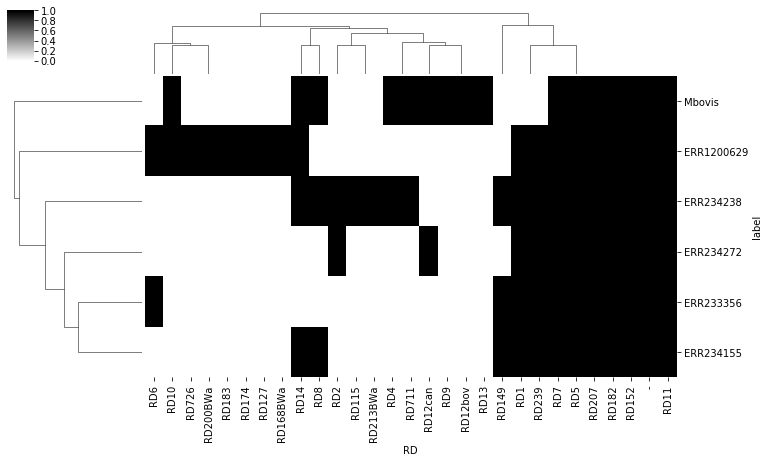

In [34]:
fig = analysis.plot_RD(rdmat.T)

## use decision matrix based on RD rules to attribute strain 

- simpler than classifer
- just apply the rules and compare to known assemblies

In [66]:
rulesmat = pd.read_csv('../mtbdiff/data/RD_rules.csv').set_index('variant').drop(columns=['rule','species'])
#rdmat

In [49]:
rd

label,ERR1200629,ERR233356,ERR234155,ERR234238,ERR234272,Mbovis
RD,,,,,,
-,1.0,1.0,1.0,1.0,1.0,1.0
RD1,1.0,1.0,1.0,1.0,1.0,0.0
RD10,1.0,0.0,0.0,0.0,0.0,1.0
RD11,1.0,1.0,1.0,1.0,1.0,1.0
RD115,0.0,0.0,0.0,1.0,0.0,0.0
RD127,1.0,0.0,0.0,0.0,0.0,0.0
RD12bov,0.0,0.0,0.0,0.0,0.0,1.0
RD12can,0.0,0.0,0.0,0.0,1.0,1.0
RD13,0.0,0.0,0.0,0.0,0.0,1.0
